In [1]:
#using pytorch
#cnnlstm on sequence level (not frame)

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # order devices by bus id
os.environ["CUDA_VISIBLE_DEVICES"]="0" # only make device 0 visible

In [4]:
%matplotlib inline
from platform import python_version
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageEnhance
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import itertools
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import image as matplotimage
from os import listdir

from IPython.display import HTML, display
import pandas as pd
import statistics
import time
import re
#import cv2

In [5]:
#pytorch
from torch.nn import Module
from torch.nn import LSTM
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Softmax
from torch.nn import BatchNorm1d
from torch.nn import BatchNorm2d
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.nn.init import orthogonal_
from torch.nn.init import normal_
from torch.nn.init import calculate_gain
from torch.nn.init import zeros_
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss
from torch.autograd import Variable
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, ChainDataset
import torch.nn.functional as F
from torch.utils.data import Subset
from skimage.metrics import structural_similarity as ssim
from torch import nn
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from collections import Counter

In [6]:
print("running python: " + python_version())

running python: 3.6.9


In [7]:
if torch.cuda.is_available():
    print("CUDA available")
else:
    print("Could not find CUDA, possibly encountering problems with current CUDA version")

CUDA available


In [8]:
print("GPUs available: ", torch.cuda.device_count()) # show number of cuda devices

GPUs available:  1


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
print(device)

cuda


In [14]:
print("The currently selected GPU is number:", torch.cuda.current_device(),
      ", it's a ", torch.cuda.get_device_name(device=None))

The currently selected GPU is number: 0 , it's a  NVIDIA GeForce GTX 1080


In [15]:
print("GPUs available: ", torch.cuda.device_count())
for device in range(torch.cuda.device_count()):
    print("Device",device, ":", torch.cuda.get_device_name(device=device))

GPUs available:  1
Device 0 : NVIDIA GeForce GTX 1080


In [16]:
classes = ['abort','circle', 'hello', 'no', 'stop', 'turn_left', 'turn_right', 
         'turn', 'warn']
l_e = LabelEncoder()
l_e.fit(classes)
print(l_e.classes_)

['abort' 'circle' 'hello' 'no' 'stop' 'turn' 'turn_left' 'turn_right'
 'warn']


In [19]:
#prediction on sequence level
class GRITDataset(Dataset):

    def __init__(self, path='/path/to/grit_preprocessed_frames',
                kendon_path='/path/to/grit_kendon',
                participants=[1,2,3,4,5,6]
                ):
        self.x_samples = []
        self.y_labels = []
        self.gesture_peak = []
        self.gesture_peak_original = []
        self.x_lengths = []
        self.file_names = []
        # load all images in a directory
        for folder in listdir(path): #abort, circle, etc.
            if folder in classes:
                print(folder)
                for subfolder in listdir(os.path.join(path,folder)): #1_1, 1_2, etc.
                    if int(subfolder[0]) in participants:
                        print(subfolder)
                        loaded_images = [] #has all images in folder
                        loaded_labels = []
                        for filename in sorted(listdir(os.path.join(path,folder,subfolder)) ,key=lambda x: int(os.path.splitext(x)[0])): #1, 2, etc.
                            #print(filename)
                            # load image
                            img_file = Image.open(os.path.join(path, folder, subfolder, filename))
                            img_data = np.asarray(img_file)
                            # store loaded image  
                            if (len(loaded_images) < 100): #100 or any large number, to put everything inside array
                                loaded_images.append(np.transpose(img_data / 255.0))
                                loaded_labels.append(folder)
                            #print('> loaded %s %s' % (filename, img_data.shape))
                        #print(np.shape(loaded_images))
                        if (len(loaded_images) > 22): #22 here is the wanted sequence length
                            #print("#frames: ", len(loaded_images)) 
                            #take first frames again
                            loaded_images = loaded_images[:22]
                            self.x_lengths.append(22)
                        else:
                            self.x_lengths.append(len(loaded_images))
                            loaded_images = np.pad(loaded_images, ((22-len(loaded_images), 0),(0,0),(0,0)), 'constant', constant_values=[0])

                        self.y_labels.append(folder)
                        self.file_names.append(folder+subfolder)
                        img_file_kendon = Image.open(os.path.join(kendon_path, folder, subfolder, "1_hand.jpg")).convert('L')
                        self.gesture_peak_original.append(img_file_kendon)
                        img_data_kendon = np.asarray(img_file_kendon)
                        self.gesture_peak.append(np.reshape(np.transpose(img_data_kendon / 255.0), (1, 64, 48)))
                        loaded_images = np.array(loaded_images)
                        #loaded_images = np.append(loaded_images, np.transpose(img_data_kendon / 255.0))
                        print(np.shape(loaded_images))
                        loaded_images = np.reshape(loaded_images, (-1, 1, 64, 48))
                        print(np.shape(loaded_images))
                        self.x_samples.append(loaded_images)
        self.y_labels = l_e.fit_transform(self.y_labels)
    def __len__(self):
        return len(self.x_samples)

    def __getitem__(self, idx):
        #return self.x_samples[idx], self.y_labels[idx]
        return self.x_samples[idx], self.y_labels[idx], self.gesture_peak[idx]#, self.gesture_peak_original[idx]

In [20]:
gritdataset = GRITDataset()

circle
3_4
(22, 64, 48)
(22, 1, 64, 48)
5_7
(22, 64, 48)
(22, 1, 64, 48)
1_2
(22, 64, 48)
(22, 1, 64, 48)
4_1
(22, 64, 48)
(22, 1, 64, 48)
3_3
(22, 64, 48)
(22, 1, 64, 48)
2_4
(22, 64, 48)
(22, 1, 64, 48)
4_2
(22, 64, 48)
(22, 1, 64, 48)
1_9
(22, 64, 48)
(22, 1, 64, 48)
6_5
(22, 64, 48)
(22, 1, 64, 48)
2_10
(22, 64, 48)
(22, 1, 64, 48)
6_2
(22, 64, 48)
(22, 1, 64, 48)
2_7
(22, 64, 48)
(22, 1, 64, 48)
3_9
(22, 64, 48)
(22, 1, 64, 48)
5_2
(22, 64, 48)
(22, 1, 64, 48)
2_5
(22, 64, 48)
(22, 1, 64, 48)
6_3
(22, 64, 48)
(22, 1, 64, 48)
1_5
(22, 64, 48)
(22, 1, 64, 48)
2_0
(22, 64, 48)
(22, 1, 64, 48)
6_4
(22, 64, 48)
(22, 1, 64, 48)
3_0
(22, 64, 48)
(22, 1, 64, 48)
2_6
(22, 64, 48)
(22, 1, 64, 48)
3_7
(22, 64, 48)
(22, 1, 64, 48)
5_8
(22, 64, 48)
(22, 1, 64, 48)
1_8
(22, 64, 48)
(22, 1, 64, 48)
4_9
(22, 64, 48)
(22, 1, 64, 48)
5_4
(22, 64, 48)
(22, 1, 64, 48)
5_9
(22, 64, 48)
(22, 1, 64, 48)
3_5
(22, 64, 48)
(22, 1, 64, 48)
6_9
(22, 64, 48)
(22, 1, 64, 48)
2_1
(22, 64, 48)
(22, 1, 64, 48)
5_

In [21]:
print(np.shape(gritdataset.x_samples))
print(np.shape(gritdataset.y_labels))
print(np.shape(gritdataset.gesture_peak))

(543, 22, 1, 64, 48)
(543,)
(543, 1, 64, 48)


(543, 22, 1, 64, 48)
(1, 64, 48)


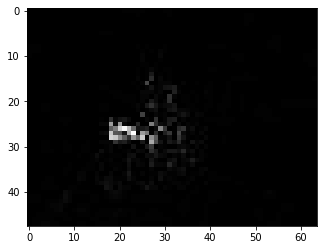

In [22]:
print(np.shape(gritdataset.x_samples))
print(np.shape(gritdataset.x_samples[0][10]))
plt.imshow(np.transpose(np.reshape(gritdataset.x_samples[10][21], (64, 48))), cmap="gray") 

In [25]:
#splitting sequences as wholes
train_size = int(0.7 * len(gritdataset))
test_size = len(gritdataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(gritdataset, [train_size, test_size], generator=torch.Generator().manual_seed(10))

In [26]:
print(np.shape(gritdataset.x_samples))
print(np.shape(gritdataset.y_labels))

(543, 22, 1, 64, 48)
(543,)


In [31]:
import random
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
cnn_init1 = None
linear_init = None
cnn_init5 = None
linear_init64 = None
linear_init1650 = None
lstm_init = None
def weights_init(m):
    global linear_init
    global linear_init64
    global linear_init1650
    global lstm_init
    global cnn_init1
    global cnn_init5
    if isinstance(m, Conv2d):
        zeros_(m.bias)
        if m.in_channels == 1:
            if cnn_init1 is None:
                cnn_init1 = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = cnn_init1
        elif m.in_channels == 5:
            if cnn_init5 is None:
                cnn_init5 = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = cnn_init5
    elif isinstance(m, Linear):
        zeros_(m.bias)
        if m.in_features == 64:
            if linear_init64 is None:
                linear_init64 = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = linear_init64
        elif m.in_features == 1650:
            if linear_init1650 is None:
                linear_init1650 = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = linear_init1650
        else:
            if linear_init is None:
                linear_init = xavier_uniform_(m.weight, calculate_gain('relu'))
            else:
                m.weight = linear_init
        
    elif isinstance(m, LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                    zeros_(param)
            elif 'weight' in name:
                if lstm_init is None:
                    lstm_init = xavier_uniform_(param)
                else:
                    param = lstm_init

In [32]:
class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2d(1, 5, (3,3))
        weights_init(self.conv1)
        self.act1 = Tanh()
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        self.conv2 = Conv2d(5, 10, (2,2))
        weights_init(self.conv2)
        self.act2 = Tanh()
        self.pool2 = MaxPool2d((2,2), stride=(2,2))
        self.fc1 = Linear(10*15*11, 500)
        weights_init(self.fc1)
        self.act3 = Tanh()
        
    def forward(self, X):
        X = self.conv1(X)
        X = self.act1(X)
        X = self.pool1(X)
        X = self.conv2(X)
        X = self.act2(X)
        X = self.pool2(X)
        X = X.view(-1, 10*15*11)
        X = self.fc1(X)
        X = self.act3(X)
        return X

In [33]:
class Snap(Module):
    def __init__(self):
        super(Snap, self).__init__()
        #init vals?
        self.conv1 = Conv2d(1, 5, (3,3))
        self.act1 = Tanh()
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        self.conv2 = Conv2d(5, 10, (2,2))
        self.act2 = Tanh()
        self.pool2 = MaxPool2d((2,2), stride=(2,2))
        
    def forward(self, X):
        
        X = self.conv1(X)
        X = self.act1(X)
        X = self.pool1(X)
        X = self.conv2(X)
        X = self.act2(X)
        X = self.pool2(X)
        X = X.view(-1, 10*15*11)
        return X

In [34]:
#sequence level
class CNNLSTM(Module):        
    def __init__(
            self,
            input_size=500, 
            hidden_size=64,
            hidden_size_snapture=200,
            num_layers=2,
            batch_first=True,
            num_units=64,
            num_units_snapture=1714,
            num_classes=9,
            snapture=False
    ):
        super(CNNLSTM, self).__init__()
        #cnn for static part
        if snapture:
            #cnn for frames
            self.snap = Snap().to('cuda:0')
            self.snap.double()
    
        #cnn for frames
        self.cnn = CNN().to('cuda:0')
        self.cnn.double()
        
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.batch_first=batch_first
        self.num_units=num_units
        self.num_classes=num_classes
        self.snapture=snapture
        
        self.rnn = LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=batch_first).to('cuda:0')
        
        weights_init(self.rnn)
       
        self.rnn.double()
        self.linear = Linear(num_units, num_classes).to('cuda:0')
        weights_init(self.linear)
        self.linear.double()
        if snapture:
            self.act3 = Tanh()
            self.linear2 = Linear(num_units_snapture,num_classes)
            self.linear2.double()
            self.linear2.to('cuda:0')

    def forward(self, x, gesture_peak):
        x = x.contiguous()
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.rnn(r_in)
        
        r_out_check_activation = self.linear(r_out[:, -1, :])
        
        if self.snapture:
            use_snapture=np.ones((9), dtype=bool)
            max_activation_index = torch.argmax(r_out_check_activation).item()
            if max_activation_index in [classes.index('circle'), classes.index('turn'), classes.index('warn')]:
                use_snapture[max_activation_index] = False
                
        r_out2 = self.linear(r_out[:, -1, :])
        
        if self.snapture:        
            for iitem, item in enumerate(use_snapture):
                if item:
                    gesture_peak_maps = self.snap(gesture_peak)
                    gesture_peak_maps = torch.cat((r_out[:, -1, :], gesture_peak_maps), dim=1)
                    r_out2[iitem] = self.linear2(gesture_peak_maps[iitem])
        
        return F.log_softmax(r_out2, dim=1)

In [37]:
def train_model(model, optimizer, num_epochs, train_loader, val_loader, device):
    
    model.train()
    loss_list = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (images, labels, peak) in enumerate(train_loader):
            images, labels, peak = images.to('cuda:0'), labels.to('cuda:0'), peak.to('cuda:0')
            outputs = model(images.double(), peak.double()).to('cuda:0') #statless

            loss = criterion(outputs, labels)
            loss_list.append(loss.item())
            
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for val_i, (val_images, val_labels, val_peak) in enumerate(val_loader):
                    val_images, val_labels, val_peak = val_images.to('cuda:0'), val_labels.to('cuda:0'), val_peak.to('cuda:0')
                    val_outputs = model(val_images.double(), val_peak.double()).to('cuda:0')
                    temp = criterion(val_outputs, val_labels)
                    val_loss+=temp.item()
                val_loss = val_loss/len(val_loader)
                val_losses.append(val_loss)
            
            model.train()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch%2 == 0:
            print('Epoch : ',epoch+1, '\t', 'loss :', loss, '\t', 'val_loss :', val_loss)
    return loss_list, val_losses

In [38]:
def test_model(model, test_loader, device):
    num_correct = 0
    total = 0
    confusion_matrix = torch.zeros(9, 9)
    model.eval()
    with torch.no_grad():
        for data, labels, peak in test_loader:
            data, labels, peak = data.to('cuda:0'), labels.to('cuda:0'), peak.to('cuda:0')
            predictions = model(data.double(), peak.double()).to('cuda:0') #statelss
            _, predicted = torch.max(predictions.data, 1)
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            num_correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc_on_test = float(num_correct)/float(total)
    print(f"Test Accuracy of the model: {acc_on_test*100:.2f}")
    return acc_on_test, [], [], confusion_matrix

In [43]:
# defining the model
model = CNNLSTM()
model.to('cuda:0')
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
    
print(model)

CNNLSTM(
  (cnn): CNN(
    (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(2, 2), stride=(1, 1))
    (act2): Tanh()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=1650, out_features=500, bias=True)
    (act3): Tanh()
  )
  (rnn): LSTM(500, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=9, bias=True)
)


In [46]:
def cnnlstm_grit(num_trials, cv_split=None):
    num_epochs = 40
    
    test_scores = []
    run_times = []
    pred_history = []
    true_history = []
    all_confusion = []
    all_lost = []
    all_val_lost=[]

    for i in range(num_trials):
        trial_scores = []
        trial_times = []
        trial_predictions = []
        trial_ground_truth = []
        trial_conf = []
        trial_lost = []
        trial_val_lost=[]
        all_y = np.array([y for x, y, z in iter(gritdataset)])
        cv_folds = StratifiedKFold(n_splits=cv_split, shuffle=True, random_state=i)
        for cv_fold, (train_indices, test_indices) in enumerate(cv_folds.split(gritdataset, all_y)):
            train_dataset = torch.utils.data.SubsetRandomSampler(train_indices)
            test_dataset = torch.utils.data.SubsetRandomSampler(test_indices)

            train_loader = DataLoader(gritdataset, batch_size=64, shuffle=False, num_workers=0,  drop_last=False, sampler=train_dataset)
            test_loader = DataLoader(gritdataset, batch_size=64, shuffle=False, num_workers=0,  drop_last=False, sampler=test_dataset)

            # defining the model
            model = CNNLSTM()
            model.to('cuda:0')
            optimizer = Adam(model.parameters(), lr=0.001)
            # defining the loss function
            criterion = CrossEntropyLoss()
            #print(model)
            
            start = time.process_time() 
            loss_list, val_losses = train_model(model, optimizer, num_epochs, train_loader, test_loader, device)#should be val
            trial_times.append(time.process_time() - start)
            acc, preds, labels, confusion_matrix = test_model(model, test_loader, device)
            trial_conf.append(confusion_matrix)
            trial_predictions.append(preds)
            trial_ground_truth.append(labels)
            trial_scores.append(acc) #whole_sequence
            trial_lost.append(loss_list)
            trial_val_lost.append(val_losses)
        all_lost.append(loss_list)
        all_val_lost.append(val_losses)
        test_scores.append(trial_scores)
        run_times.append(trial_times)
        pred_history.append(trial_predictions)
        true_history.append(trial_ground_truth)
        all_confusion.append(trial_conf)
    return run_times, test_scores, pred_history, true_history, loss_list, val_losses, acc, all_confusion

In [47]:
num_trials = 5
cv_split = 3
run_times, test_scores, pred_history, true_history, loss_list, val_losses, acc, conf_mat = cnnlstm_grit(num_trials, cv_split)

/data/7ali/mg101/venv/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch :  1 	 loss : tensor(2.1258, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 2.1077730028336967
Epoch :  3 	 loss : tensor(1.7730, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 1.7225060439500368
Epoch :  5 	 loss : tensor(1.1128, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 1.3341704841731523
Epoch :  7 	 loss : tensor(0.9363, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 1.1409075877162433
Epoch :  9 	 loss : tensor(0.8836, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.9930228758841966
Epoch :  11 	 loss : tensor(0.4843, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.7551366198285242
Epoch :  13 	 loss : tensor(0.4981, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.7799552644231893
Epoch :  15 	 loss : tensor(0.3106, device='cuda:0', dtype=torch.float64, 

In [49]:
#test_scores: all cv splits of all trials in format (acc_frame_by_frame, acc_whole_sequence)
test_scores = np.asarray(test_scores)
print(test_scores)
#mean test results for each trial
mean_test_scores_per_trial = np.mean(test_scores, axis=1)
print(mean_test_scores_per_trial)
print(np.mean(mean_test_scores_per_trial))

[[0.83425414 0.90607735 0.91712707]
 [0.90055249 0.8839779  0.95027624]
 [0.93922652 0.89502762 0.90607735]
 [0.89502762 0.9281768  0.9281768 ]
 [0.91712707 0.90055249 0.94475138]]
[0.88581952 0.91160221 0.91344383 0.91712707 0.92081031]
0.9097605893186003


In [54]:
#test_scores: all cv splits of all trials in format (acc_frame_by_frame, acc_whole_sequence)
run_times = np.asarray(run_times)
print(run_times)
#mean test results for each trial
mean_run_times_per_trial = np.mean(run_times, axis=1)
print(mean_run_times_per_trial)
print(np.mean(mean_run_times_per_trial))

[[140.74073744 139.6862591  141.05932564]
 [140.96871604 140.58847191 140.66067045]
 [140.21523853 140.89995366 140.74312951]
 [139.6459288  140.97354587 140.03371678]
 [140.51395147 142.22475406 140.22216041]]
[140.49544073 140.73928614 140.61944056 140.21773048 140.98695531]
140.61177064353333


In [59]:
all_f1 = []
for one_trial_confs in conf_mat:
    one_trial_f1 = []
    for one_trial_conf in one_trial_confs:
        recall = np.diag(one_trial_conf.numpy()) / np.sum(one_trial_conf.numpy(), axis = 1)
        precision = np.diag(one_trial_conf.numpy()) / np.sum(one_trial_conf.numpy(), axis = 0)
        recall = np.mean(recall)
        precision = np.mean(precision)
        one_trial_f1.append(2 * (precision * recall) / (precision + recall))
    all_f1.append(one_trial_f1)

In [61]:
#test_scores: all cv splits of all trials in format (acc_frame_by_frame, acc_whole_sequence)
all_f1 = np.asarray(all_f1)
print(all_f1)
#mean test results for each trial
mean_f1_per_trial = np.mean(all_f1, axis=1)
print(mean_f1_per_trial)
print(np.mean(mean_f1_per_trial))

[[0.84043363 0.91177935 0.91964646]
 [0.90621076 0.88395816 0.95078671]
 [0.94090641 0.89884098 0.90998352]
 [0.89854008 0.92942875 0.92967056]
 [0.91854648 0.90488554 0.94806643]]
[0.89061981 0.91365188 0.91657697 0.91921313 0.92383282]
0.9127789211298383


In [62]:
for one_trial_confs in conf_mat:
    for one_trial_conf in one_trial_confs:
        print(one_trial_conf)

tensor([[18.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 14.,  3.,  1.,  1.,  0.,  0.,  1.],
        [ 0.,  0.,  2., 15.,  2.,  0.,  0.,  0.,  2.],
        [ 2.,  0.,  2.,  2., 14.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  2.,  1.,  0., 17.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0., 19.,  0.,  0.],
        [ 0.,  0.,  1.,  1.,  0.,  0.,  0., 18.,  0.],
        [ 0.,  0.,  2.,  2.,  0.,  0.,  0.,  0., 16.]])
tensor([[19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 3.,  0., 13.,  2.,  1.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., 18.,  0.,  0.,  0.,  1.,  1.],
        [ 1.,  0.,  0.,  4., 15.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0., 19.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 21.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 19.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.]])
tensor([

In [67]:
all_conf_avg = []
for one_trial_confs in conf_mat:
    temp = []
    for one_trial_conf in one_trial_confs:
        temp.append(np.array(one_trial_conf))
    all_conf_avg.append(np.mean(np.array(temp), axis=0))
    print(np.mean(np.array(temp), axis=0))
    print()
    print()

[[18.333334    0.          0.33333334  0.          0.33333334  0.
   0.          0.          0.        ]
 [ 0.         20.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.         14.666667    1.6666666   1.3333334   0.33333334
   0.          0.33333334  0.33333334]
 [ 0.          0.          2.         16.333334    0.6666667   0.
   0.          0.33333334  1.3333334 ]
 [ 1.3333334   0.          0.6666667   2.6666667  15.333333    0.
   0.          0.          0.        ]
 [ 0.          0.33333334  1.3333334   0.6666667   0.         18.333334
   0.          0.          0.33333334]
 [ 0.          0.33333334  0.          0.          0.          0.33333334
  20.          0.          0.        ]
 [ 0.          0.          0.33333334  0.33333334  0.          0.
   0.         19.          0.33333334]
 [ 0.          0.          0.6666667   1.          0.          0.
   0.          0.         18.333334  ]]


[[18.333334    0.          0.3

In [68]:
print(np.mean(np.array(all_conf_avg), axis=0))

[[18.466667    0.          0.2         0.06666667  0.26666668  0.
   0.          0.          0.        ]
 [ 0.06666667 19.666666    0.13333334  0.          0.          0.
   0.13333334  0.          0.        ]
 [ 0.33333334  0.26666668 15.466667    1.6666666   0.9999999   0.46666664
   0.          0.06666667  0.4       ]
 [ 0.          0.          1.6        16.866667    1.          0.26666668
   0.          0.06666667  0.8666667 ]
 [ 1.0666667   0.          0.26666668  0.8666666  17.666668    0.06666667
   0.          0.06666667  0.        ]
 [ 0.          0.13333334  0.8000001   1.          0.13333334 18.8
   0.06666667  0.          0.06666667]
 [ 0.          0.13333334  0.06666667  0.          0.          0.2
  20.066668    0.          0.2       ]
 [ 0.          0.          0.2         0.13333334  0.2         0.
   0.         18.866667    0.6       ]
 [ 0.13333334  0.06666667  0.33333334  0.6         0.          0.06666667
   0.          0.         18.800001  ]]


In [69]:
from matplotlib.pyplot import figure
def displayConfMat(confusion_matrix, save_file_name):
    #confusion_matrix = confusion_matrix.numpy()
    #print(confusion_matrix)
    font = {'size'   : 5}
    plt.rc('font', **font)
    figure(num=None, figsize=(1080, 1080), dpi=300, facecolor='w', edgecolor='k')
    plt_conf = ConfusionMatrixDisplay(confusion_matrix=np.array(confusion_matrix),
                                  display_labels=np.array(classes))
    plt_conf.plot(xticks_rotation='vertical', cmap='Blues',values_format='.5g')
    plt.gcf().subplots_adjust(bottom=0.19)
    plt_conf.figure_.savefig(save_file_name, dpi=300)

Results for CNNLSTM - best case
Accuracy: 0.92081
F1: 0.92383
Results for CNNLSTM - worst case
Accuracy: 0.88582
F1: 0.89062
Results for CNNLSTM - avg case
Accuracy: 0.90976
F1: 0.91278


<Figure size 324000x324000 with 0 Axes>

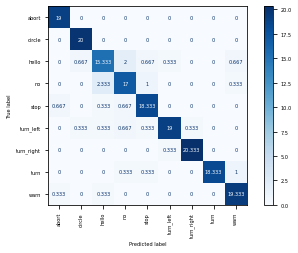

<Figure size 324000x324000 with 0 Axes>

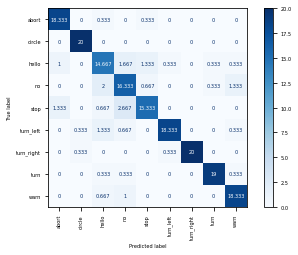

<Figure size 324000x324000 with 0 Axes>

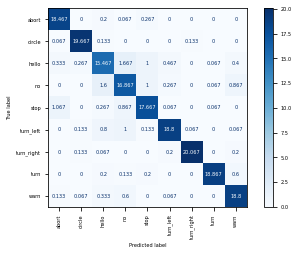

In [75]:
nb_classes = 9
print("===============================")
print("Results for CNNLSTM - best case")
best = np.argmax(mean_test_scores_per_trial)
print("Accuracy:", round(mean_test_scores_per_trial[best], 5))
print("F1:", round(mean_f1_per_trial[best], 5))
print("===============================")
displayConfMat(all_conf_avg[best].round(3), "3_cross_just_cnnlstm_grit_best_30_70_5_9_2021_bigger.png")

print("===============================")
print("Results for CNNLSTM - worst case")
worst = np.argmin(mean_test_scores_per_trial)
print("Accuracy:", round(mean_test_scores_per_trial[worst], 5))
print("F1:", round(mean_f1_per_trial[worst], 5))
print("===============================")
displayConfMat(all_conf_avg[worst].round(3), "3_cross_just_cnnlstm_grit_worst_30_70_5_9_2021_bigger.png")

print("===============================")
print("Results for CNNLSTM - avg case")
worst = np.mean(mean_test_scores_per_trial)
print("Accuracy:", round(np.mean(mean_test_scores_per_trial), 5))
print("F1:", round(np.mean(mean_f1_per_trial), 5))
print("===============================")
#temp = []
#for conf in all_confusion:
#    temp.append(np.array(conf))
#print(np.mean(np.array(temp), axis=0))
whatever = np.mean(np.array(all_conf_avg), axis=0)
displayConfMat(whatever.round(3), "3_cross_just_cnnlstm_grit_avg_30_70_5_9_2021_bigger.png")


In [50]:
# defining the model
model = CNNLSTM(snapture=True)
model.to('cuda:0')
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
    
print(model)

CNNLSTM(
  (snap): Snap(
    (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(2, 2), stride=(1, 1))
    (act2): Tanh()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (cnn): CNN(
    (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(2, 2), stride=(1, 1))
    (act2): Tanh()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=1650, out_features=500, bias=True)
    (act3): Tanh()
  )
  (rnn): LSTM(500, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=9, bias=True)
  (act3): Tanh()
  (linear2): Linear(i

In [51]:
def cnnlstm_grit_snapture(num_trials, cv_split=None):
    num_epochs = 40
    
    test_scores = []
    run_times = []
    pred_history = []
    true_history = []
    all_confusion = []
    all_lost = []
    all_val_lost=[]

    for i in range(num_trials):
        trial_scores = []
        trial_times = []
        trial_predictions = []
        trial_ground_truth = []
        trial_conf = []
        trial_lost = []
        trial_val_lost=[]
        all_y = np.array([y for x, y, z in iter(gritdataset)])
        cv_folds = StratifiedKFold(n_splits=cv_split, shuffle=True, random_state=i)
        for cv_fold, (train_indices, test_indices) in enumerate(cv_folds.split(gritdataset, all_y)):
            train_dataset = torch.utils.data.SubsetRandomSampler(train_indices)
            test_dataset = torch.utils.data.SubsetRandomSampler(test_indices)

            train_loader = DataLoader(gritdataset, batch_size=64, shuffle=False, num_workers=0,  drop_last=False, sampler=train_dataset)
            test_loader = DataLoader(gritdataset, batch_size=64, shuffle=False, num_workers=0,  drop_last=False, sampler=test_dataset)

            # defining the model
            model = CNNLSTM(snapture=True)
            model.to('cuda:0')
            optimizer = Adam(model.parameters(), lr=0.001)
            # defining the loss function
            criterion = CrossEntropyLoss()
            #print(model)
            
            start = time.process_time() 
            loss_list, val_losses = train_model(model, optimizer, num_epochs, train_loader, test_loader, device)#should be val
            trial_times.append(time.process_time() - start)
            acc, preds, labels, confusion_matrix = test_model(model, test_loader, device)
            trial_conf.append(confusion_matrix)
            trial_predictions.append(preds)
            trial_ground_truth.append(labels)
            trial_scores.append(acc) #whole_sequence
            trial_lost.append(loss_list)
            trial_val_lost.append(val_losses)
        all_lost.append(loss_list)
        all_val_lost.append(val_losses)
        test_scores.append(trial_scores)
        run_times.append(trial_times)
        pred_history.append(trial_predictions)
        true_history.append(trial_ground_truth)
        all_confusion.append(trial_conf)
    return run_times, test_scores, pred_history, true_history, loss_list, val_losses, acc, all_confusion

In [52]:
num_trials = 5
cv_split = 3
run_times_snapture, test_scores_snapture, pred_history_snapture, true_history_snapture, loss_list_snapture, val_losses_snapture, acc_snapture, conf_mat_snapture = cnnlstm_grit_snapture(num_trials, cv_split)

Epoch :  1 	 loss : tensor(1.8141, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 1.720311953410584
Epoch :  3 	 loss : tensor(0.9676, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.9816824441154949
Epoch :  5 	 loss : tensor(0.5491, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.6638087659515298
Epoch :  7 	 loss : tensor(0.4262, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.5355776160384346
Epoch :  9 	 loss : tensor(0.3513, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.5719585211453088
Epoch :  11 	 loss : tensor(0.3105, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.49954642583208614
Epoch :  13 	 loss : tensor(0.1776, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.46326591941927897
Epoch :  15 	 loss : tensor(0.2183, device='cuda:0', dtype=torch.float64,

In [53]:
#test_scores: all cv splits of all trials in format (acc_frame_by_frame, acc_whole_sequence)
test_scores_snapture = np.asarray(test_scores_snapture)
print(test_scores_snapture)
#mean test results for each trial
mean_test_scores_per_trial_snapture = np.mean(test_scores_snapture, axis=1)
print(mean_test_scores_per_trial_snapture)
print(np.mean(mean_test_scores_per_trial_snapture))

[[0.8839779  0.92265193 0.93922652]
 [0.89502762 0.8839779  0.92265193]
 [0.95027624 0.92265193 0.90055249]
 [0.95027624 0.96685083 0.91712707]
 [0.93370166 0.92265193 0.92265193]]
[0.91528545 0.90055249 0.92449355 0.94475138 0.92633517]
0.9222836095764272


In [55]:
#test_scores: all cv splits of all trials in format (acc_frame_by_frame, acc_whole_sequence)
run_times_snapture = np.asarray(run_times_snapture)
print(run_times_snapture)
#mean test results for each trial
mean_run_times_per_trial_snapture = np.mean(run_times_snapture, axis=1)
print(mean_run_times_per_trial_snapture)
print(np.mean(mean_run_times_per_trial_snapture))

[[172.76380328 172.06960765 171.2258079 ]
 [172.88120283 172.26791362 171.93563082]
 [172.08997154 172.35302242 173.79279244]
 [172.93996635 173.91201556 171.11345411]
 [174.6581861  171.66760939 174.53918754]]
[172.01973961 172.36158242 172.74526213 172.65514534 173.62166101]
172.68067810220003


In [76]:
all_f1_snapture = []
for one_trial_confs_snapture in conf_mat_snapture:
    one_trial_f1_snapture = []
    for one_trial_conf_snapture in one_trial_confs_snapture:
        recall = np.diag(one_trial_conf_snapture.numpy()) / np.sum(one_trial_conf_snapture.numpy(), axis = 1)
        precision = np.diag(one_trial_conf_snapture.numpy()) / np.sum(one_trial_conf_snapture.numpy(), axis = 0)
        recall = np.mean(recall)
        precision = np.mean(precision)
        one_trial_f1_snapture.append(2 * (precision * recall) / (precision + recall))
    all_f1_snapture.append(one_trial_f1_snapture)

In [77]:
#test_scores: all cv splits of all trials in format (acc_frame_by_frame, acc_whole_sequence)
all_f1_snapture = np.asarray(all_f1_snapture)
print(all_f1_snapture)
#mean test results for each trial
mean_f1_per_trial_snapture = np.mean(all_f1_snapture, axis=1)
print(mean_f1_per_trial_snapture)
print(np.mean(mean_f1_per_trial_snapture))

[[0.88668856 0.92590535 0.94111755]
 [0.89942976 0.88958818 0.92544402]
 [0.95077967 0.92568816 0.90388557]
 [0.95305043 0.96770074 0.919719  ]
 [0.93515745 0.92544934 0.92594344]]
[0.91790382 0.90482065 0.92678447 0.94682339 0.92885007]
0.9250364811878745


In [78]:
for one_trial_confs_snapture in conf_mat_snapture:
    for one_trial_conf_snapture in one_trial_confs_snapture:
        print(one_trial_conf_snapture)

tensor([[17.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  2., 15.,  2.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  0.,  2., 16.,  2.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  1., 18.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  2.,  1.,  1., 17.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 20.,  0.,  0.],
        [ 0.,  1.,  1.,  0.,  0.,  0.,  0., 18.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 19.]])
tensor([[19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1., 14.,  3.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 18.,  1.,  0.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  1., 18.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0., 18.,  0.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 21.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 19.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.]])
tensor([

In [79]:
all_conf_avg_snapture = []
for one_trial_confs_snapture in conf_mat_snapture:
    temp = []
    for one_trial_conf_snapture in one_trial_confs_snapture:
        temp.append(np.array(one_trial_conf_snapture))
    all_conf_avg_snapture.append(np.mean(np.array(temp), axis=0))
    print(np.mean(np.array(temp), axis=0))
    print()
    print()

[[18.          0.          0.33333334  0.          0.6666667   0.
   0.          0.          0.        ]
 [ 0.         20.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.33333334  1.         15.          1.6666666   0.6666667   0.33333334
   0.          0.33333334  0.33333334]
 [ 0.6666667   0.          1.3333334  16.666666    1.3333334   0.33333334
   0.          0.          0.33333334]
 [ 0.6666667   0.          0.          0.6666667  18.666666    0.
   0.          0.          0.        ]
 [ 0.          0.          0.6666667   0.6666667   0.33333334 18.666666
   0.          0.33333334  0.33333334]
 [ 0.          0.          0.          0.          0.          0.33333334
  20.333334    0.          0.        ]
 [ 0.          0.33333334  0.33333334  0.          0.          0.
   0.         19.          0.33333334]
 [ 0.          0.          0.          0.          0.33333334  0.
   0.          0.33333334 19.333334  ]]


[[18.333334    0.     

In [ ]:
from matplotlib.pyplot import figure
def displayConfMat(confusion_matrix, save_file_name):
    #confusion_matrix = confusion_matrix.numpy()
    #print(confusion_matrix)
    font = {'size'   : 5}
    plt.rc('font', **font)
    figure(num=None, figsize=(1080, 1080), dpi=300, facecolor='w', edgecolor='k')
    plt_conf = ConfusionMatrixDisplay(confusion_matrix=np.array(confusion_matrix),
                                  display_labels=np.array(classes))
    plt_conf.plot(xticks_rotation='vertical', cmap='Blues',values_format='.5g')
    plt.gcf().subplots_adjust(bottom=0.19)
    plt_conf.figure_.savefig(save_file_name, dpi=300)

Results for Snapture - best case
Accuracy: 0.94475
F1: 0.94682
Results for Snapture - worst case
Accuracy: 0.90055
F1: 0.90482
Results for Snapture - avg case
Accuracy: 0.92228
F1: 0.92504


<Figure size 324000x324000 with 0 Axes>

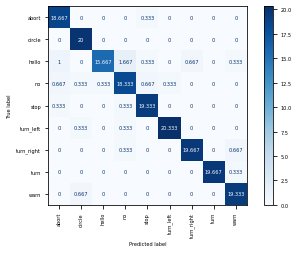

<Figure size 324000x324000 with 0 Axes>

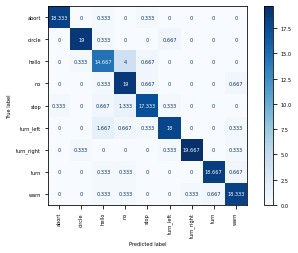

<Figure size 324000x324000 with 0 Axes>

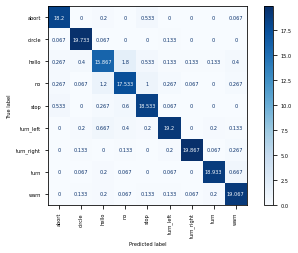

In [80]:
nb_classes = 9
print("===============================")
print("Results for Snapture - best case")
best = np.argmax(mean_test_scores_per_trial_snapture)
print("Accuracy:", round(mean_test_scores_per_trial_snapture[best], 5))
print("F1:", round(mean_f1_per_trial_snapture[best], 5))
print("===============================")
displayConfMat(all_conf_avg_snapture[best].round(3), "3_cross_just_snapture_grit_best_30_70_5_9_2021_bigger.png")

print("===============================")
print("Results for Snapture - worst case")
worst = np.argmin(mean_test_scores_per_trial_snapture)
print("Accuracy:", round(mean_test_scores_per_trial_snapture[worst], 5))
print("F1:", round(mean_f1_per_trial_snapture[worst], 5))
print("===============================")
displayConfMat(all_conf_avg_snapture[worst].round(3), "3_cross_just_snapture_grit_worst_30_70_5_9_2021_bigger.png")

print("===============================")
print("Results for Snapture - avg case")
worst = np.mean(mean_test_scores_per_trial_snapture)
print("Accuracy:", round(np.mean(mean_test_scores_per_trial_snapture), 5))
print("F1:", round(np.mean(mean_f1_per_trial_snapture), 5))
print("===============================")
#temp = []
#for conf in all_confusion:
#    temp.append(np.array(conf))
#print(np.mean(np.array(temp), axis=0))
whatever = np.mean(np.array(all_conf_avg_snapture), axis=0)
displayConfMat(whatever.round(3), "3_cross_just_snapture_grit_avg_30_70_5_9_2021_bigger.png")


In [ ]:
#snapture all classes

In [81]:
#sequence level
class CNNLSTMALL(Module):        
    def __init__(
            self,
            input_size=500, 
            hidden_size=64,
            hidden_size_snapture=200,
            num_layers=2,
            batch_first=True,
            num_units=64,
            num_units_snapture=1714,
            num_classes=9,
            snapture=False
    ):
        super(CNNLSTMALL, self).__init__()
        #cnn for static part
        if snapture:
            #cnn for frames
            self.snap = Snap().to('cuda:0')
            self.snap.double()
    
        #cnn for frames
        self.cnn = CNN().to('cuda:0')
        self.cnn.double()
        
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.batch_first=batch_first
        self.num_units=num_units
        self.num_classes=num_classes
        self.snapture=snapture
        
        self.rnn = LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=batch_first).to('cuda:0')
        
        weights_init(self.rnn)
       
        self.rnn.double()
        self.linear = Linear(num_units, num_classes).to('cuda:0')
        weights_init(self.linear)
        self.linear.double()
        if snapture:
            self.act3 = Tanh()
            self.linear2 = Linear(num_units_snapture,num_classes)
            self.linear2.double()
            self.linear2.to('cuda:0')

    def forward(self, x, gesture_peak):
        x = x.contiguous()
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.rnn(r_in)
        
        r_out_check_activation = self.linear(r_out[:, -1, :])
        
        if self.snapture:
            use_snapture=np.ones((9), dtype=bool)
                
        r_out2 = self.linear(r_out[:, -1, :])
        
        if self.snapture:        
            for iitem, item in enumerate(use_snapture):
                if True:
                    gesture_peak_maps = self.snap(gesture_peak)
                    gesture_peak_maps = torch.cat((r_out[:, -1, :], gesture_peak_maps), dim=1)
                    r_out2[iitem] = self.linear2(gesture_peak_maps[iitem])
        
        return F.log_softmax(r_out2, dim=1)


In [82]:
# defining the model
model = CNNLSTMALL(snapture=True)
model.to('cuda:0')
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
    
print(model)

CNNLSTMALL(
  (snap): Snap(
    (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(2, 2), stride=(1, 1))
    (act2): Tanh()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (cnn): CNN(
    (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(2, 2), stride=(1, 1))
    (act2): Tanh()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=1650, out_features=500, bias=True)
    (act3): Tanh()
  )
  (rnn): LSTM(500, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=9, bias=True)
  (act3): Tanh()
  (linear2): Linea

In [83]:
def cnnlstm_grit_snapture_all(num_trials, cv_split=None):
    num_epochs = 40
    
    test_scores = []
    run_times = []
    pred_history = []
    true_history = []
    all_confusion = []
    all_lost = []
    all_val_lost=[]

    for i in range(num_trials):
        trial_scores = []
        trial_times = []
        trial_predictions = []
        trial_ground_truth = []
        trial_conf = []
        trial_lost = []
        trial_val_lost=[]
        all_y = np.array([y for x, y, z in iter(gritdataset)])
        cv_folds = StratifiedKFold(n_splits=cv_split, shuffle=True, random_state=i)
        for cv_fold, (train_indices, test_indices) in enumerate(cv_folds.split(gritdataset, all_y)):
            train_dataset = torch.utils.data.SubsetRandomSampler(train_indices)
            test_dataset = torch.utils.data.SubsetRandomSampler(test_indices)

            train_loader = DataLoader(gritdataset, batch_size=64, shuffle=False, num_workers=0,  drop_last=False, sampler=train_dataset)
            test_loader = DataLoader(gritdataset, batch_size=64, shuffle=False, num_workers=0,  drop_last=False, sampler=test_dataset)

            # defining the model
            model = CNNLSTMALL(snapture=True)
            model.to('cuda:0')
            optimizer = Adam(model.parameters(), lr=0.001)
            # defining the loss function
            criterion = CrossEntropyLoss()
            #print(model)
            
            start = time.process_time() 
            loss_list, val_losses = train_model(model, optimizer, num_epochs, train_loader, test_loader, device)#should be val
            trial_times.append(time.process_time() - start)
            acc, preds, labels, confusion_matrix = test_model(model, test_loader, device)
            trial_conf.append(confusion_matrix)
            trial_predictions.append(preds)
            trial_ground_truth.append(labels)
            trial_scores.append(acc) #whole_sequence
            trial_lost.append(loss_list)
            trial_val_lost.append(val_losses)
        all_lost.append(loss_list)
        all_val_lost.append(val_losses)
        test_scores.append(trial_scores)
        run_times.append(trial_times)
        pred_history.append(trial_predictions)
        true_history.append(trial_ground_truth)
        all_confusion.append(trial_conf)
    return run_times, test_scores, pred_history, true_history, loss_list, val_losses, acc, all_confusion

In [84]:
num_trials = 5
cv_split = 3
run_times_snapture_all, test_scores_snapture_all, pred_history_snapture_all, true_history_snapture_all, loss_list_snapture_all, val_losses_snapture_all, acc_snapture_all, conf_mat_snapture_all = cnnlstm_grit_snapture_all(num_trials, cv_split)

Epoch :  1 	 loss : tensor(1.6581, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 1.6340273073908078
Epoch :  3 	 loss : tensor(0.8325, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.8680665114535807
Epoch :  5 	 loss : tensor(0.5369, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.5947992796816682
Epoch :  7 	 loss : tensor(0.3877, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.592069314683933
Epoch :  9 	 loss : tensor(0.4417, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.6110918691021416
Epoch :  11 	 loss : tensor(0.2449, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.5423549710728589
Epoch :  13 	 loss : tensor(0.2190, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0.3957500718737237
Epoch :  15 	 loss : tensor(0.2035, device='cuda:0', dtype=torch.float64, g

In [85]:
#test_scores: all cv splits of all trials in format (acc_frame_by_frame, acc_whole_sequence)
test_scores_snapture_all = np.asarray(test_scores_snapture_all)
print(test_scores_snapture_all)
#mean test results for each trial
mean_test_scores_per_trial_snapture_all = np.mean(test_scores_snapture_all, axis=1)
print(mean_test_scores_per_trial_snapture_all)
print(np.mean(mean_test_scores_per_trial_snapture_all))

[[0.90607735 0.96132597 0.89502762]
 [0.93922652 0.91712707 0.94475138]
 [0.9281768  0.93370166 0.91712707]
 [0.91160221 0.93922652 0.90055249]
 [0.91712707 0.91712707 0.9281768 ]]
[0.92081031 0.93370166 0.92633517 0.91712707 0.92081031]
0.9237569060773481


In [86]:
#test_scores: all cv splits of all trials in format (acc_frame_by_frame, acc_whole_sequence)
run_times_snapture_all = np.asarray(run_times_snapture_all)
print(run_times_snapture_all)
#mean test results for each trial
mean_run_times_per_trial_snapture_all = np.mean(run_times_snapture_all, axis=1)
print(mean_run_times_per_trial_snapture_all)
print(np.mean(mean_run_times_per_trial_snapture_all))

[[169.30920296 170.90191075 172.71278692]
 [170.25981565 172.87135509 170.59197668]
 [169.18108894 169.48801424 169.34528114]
 [170.89027843 170.22560685 168.995147  ]
 [170.383844   169.06244089 165.95567311]]
[170.97463354 171.24104914 169.33812811 170.03701076 168.46731934]
170.01162817793337


In [87]:
all_f1_snapture_all = []
for one_trial_confs_snapture_all in conf_mat_snapture_all:
    one_trial_f1_snapture_all = []
    for one_trial_conf_snapture_all in one_trial_confs_snapture_all:
        recall = np.diag(one_trial_conf_snapture_all.numpy()) / np.sum(one_trial_conf_snapture_all.numpy(), axis = 1)
        precision = np.diag(one_trial_conf_snapture_all.numpy()) / np.sum(one_trial_conf_snapture_all.numpy(), axis = 0)
        recall = np.mean(recall)
        precision = np.mean(precision)
        one_trial_f1_snapture_all.append(2 * (precision * recall) / (precision + recall))
    all_f1_snapture_all.append(one_trial_f1_snapture_all)

In [88]:
#test_scores: all cv splits of all trials in format (acc_frame_by_frame, acc_whole_sequence)
all_f1_snapture_all = np.asarray(all_f1_snapture_all)
print(all_f1_snapture_all)
#mean test results for each trial
mean_f1_per_trial_snapture_all = np.mean(all_f1_snapture_all, axis=1)
print(mean_f1_per_trial_snapture_all)
print(np.mean(mean_f1_per_trial_snapture_all))

[[0.91027636 0.9627349  0.90082734]
 [0.94143471 0.91953683 0.94637736]
 [0.92870976 0.93672542 0.91742068]
 [0.91957617 0.94077872 0.90316891]
 [0.91940736 0.92014403 0.93287834]]
[0.92461287 0.93578297 0.92761862 0.9211746  0.92414325]
0.9266664607485675


In [89]:
for one_trial_confs_snapture_all in conf_mat_snapture_all:
    for one_trial_conf_snapture_all in one_trial_confs_snapture_all:
        print(one_trial_conf_snapture_all)

tensor([[19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 16.,  3.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  1., 19.,  1.,  0.,  0.,  0.,  0.],
        [ 4.,  0.,  0.,  2., 14.,  0.,  0.,  0.,  0.],
        [ 0.,  2.,  0.,  0.,  0., 18.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 20.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 20.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  1., 18.]])
tensor([[19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  2., 15.,  0.,  0.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 19.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  0., 19.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 21.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 21.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 20.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.]])
tensor([

In [90]:
all_conf_avg_snapture_all = []
for one_trial_confs_snapture_all in conf_mat_snapture_all:
    temp = []
    for one_trial_conf_snapture_all in one_trial_confs_snapture_all:
        temp.append(np.array(one_trial_conf_snapture_all))
    all_conf_avg_snapture_all.append(np.mean(np.array(temp), axis=0))
    print(np.mean(np.array(temp), axis=0))
    print()
    print()

[[19.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.         20.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.33333334  1.         15.666667    1.6666666   0.          0.6666667
   0.33333334  0.          0.        ]
 [ 0.          0.          1.6666666  18.          0.33333334  0.
   0.          0.          0.6666667 ]
 [ 1.6666666   0.          0.          1.3333334  17.          0.
   0.          0.          0.        ]
 [ 0.          1.3333334   0.          0.          0.         19.
   0.33333334  0.          0.33333334]
 [ 0.          0.33333334  0.          0.          0.          0.
  20.333334    0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         19.          1.        ]
 [ 0.          1.          0.          0.          0.          0.
   0.          0.33333334 18.666666  ]]


[[17.666666    0.          0.          0.    

In [ ]:
from matplotlib.pyplot import figure
def displayConfMat(confusion_matrix, save_file_name):
    #confusion_matrix = confusion_matrix.numpy()
    #print(confusion_matrix)
    font = {'size'   : 5}
    plt.rc('font', **font)
    figure(num=None, figsize=(1080, 1080), dpi=300, facecolor='w', edgecolor='k')
    plt_conf = ConfusionMatrixDisplay(confusion_matrix=np.array(confusion_matrix),
                                  display_labels=np.array(classes))
    plt_conf.plot(xticks_rotation='vertical', cmap='Blues',values_format='.5g')
    plt.gcf().subplots_adjust(bottom=0.19)
    plt_conf.figure_.savefig(save_file_name, dpi=300)

Results for Snapture - best case
Accuracy: 0.9337
F1: 0.93578
Results for Snapture - worst case
Accuracy: 0.91713
F1: 0.92117
Results for Snapture - avg case
Accuracy: 0.92376
F1: 0.92667


<Figure size 324000x324000 with 0 Axes>

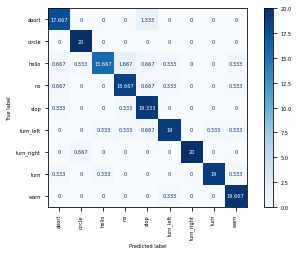

<Figure size 324000x324000 with 0 Axes>

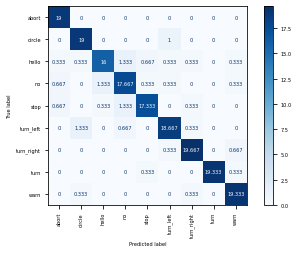

<Figure size 324000x324000 with 0 Axes>

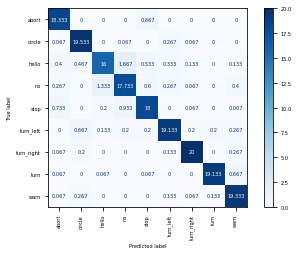

In [92]:
nb_classes = 9
print("===============================")
print("Results for Snapture - best case")
best = np.argmax(mean_test_scores_per_trial_snapture_all)
print("Accuracy:", round(mean_test_scores_per_trial_snapture_all[best], 5))
print("F1:", round(mean_f1_per_trial_snapture_all[best], 5))
print("===============================")
displayConfMat(all_conf_avg_snapture_all[best].round(3), "3_cross_just_snapture_all_grit_best_30_70_5_9_2021_bigger.png")

print("===============================")
print("Results for Snapture - worst case")
worst = np.argmin(mean_test_scores_per_trial_snapture_all)
print("Accuracy:", round(mean_test_scores_per_trial_snapture_all[worst], 5))
print("F1:", round(mean_f1_per_trial_snapture_all[worst], 5))
print("===============================")
displayConfMat(all_conf_avg_snapture_all[worst].round(3), "3_cross_just_snapture_all_grit_worst_30_70_5_9_2021_bigger.png")

print("===============================")
print("Results for Snapture - avg case")
worst = np.mean(mean_test_scores_per_trial_snapture_all)
print("Accuracy:", round(np.mean(mean_test_scores_per_trial_snapture_all), 5))
print("F1:", round(np.mean(mean_f1_per_trial_snapture_all), 5))
print("===============================")
#temp = []
#for conf in all_confusion:
#    temp.append(np.array(conf))
#print(np.mean(np.array(temp), axis=0))
whatever = np.mean(np.array(all_conf_avg_snapture_all), axis=0)
displayConfMat(whatever.round(3), "3_cross_just_snapture_all_grit_avg_30_70_5_9_2021_bigger.png")


In [106]:
#pause detection
import cv2

In [107]:
def mse(img1, img2):
    err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    err /= float(img1.shape[0] * img2.shape[1])
    return err

def diffImg(t0, t1):
    return cv2.absdiff(t0, t1)

def getdiffDir(imgs):
    #print(np.shape(imgs))
    diff = []
    all_ssim = []
    all_mse = []
    t = diffImg(imgs[0], imgs[1])
    for i, img in enumerate(imgs[2:-1]):
        im = diffImg(imgs[i-1], img)
        t += im
        all_ssim.append(1 - ssim(img.reshape(64,48), imgs[0].reshape(64,48)))
        all_mse.append(mse(img.reshape(64,48), imgs[0].reshape(64,48)))
        #t += im
        #imshow(t)
        #plt.show()
    diff.append(t)
    return all_ssim, all_mse, diff

In [108]:
#prediction on sequence level
class GRITDatasetWPause(Dataset):
    
    def __init__(self, path='/path/to/grit_preprocessed_frames',
                kendon_path='/path/to/grit_kendon',
                participants=[1,2,3,4,5,6]
                ):
        self.x_samples = []
        self.y_labels = []
        self.gesture_peak = []
        self.gesture_peak_original = []
        self.x_lengths = []
        self.file_names = []
        self.use_snapture = []
        # load all images in a directory
        for folder in listdir(path): #abort, circle, etc.
            if folder in classes:
                print(folder)
                for subfolder in listdir(os.path.join(path,folder)): #1_1, 1_2, etc.
                    if int(subfolder[0]) in participants:
                        print(subfolder)
                        loaded_images = [] #has all images in folder
                        loaded_labels = []
                        for filename in sorted(listdir(os.path.join(path,folder,subfolder)) ,key=lambda x: int(os.path.splitext(x)[0])): #1, 2, etc.
                            # load image
                            img_file = Image.open(os.path.join(path, folder, subfolder, filename))
                            img_data = np.asarray(img_file)
                            # store loaded image  
                            if (len(loaded_images) < 100): #100 or any large number, to put everything inside array
                                loaded_images.append(np.transpose(img_data / 255.0))
                                loaded_labels.append(folder)
                            #print('> loaded %s %s' % (filename, img_data.shape))
                        #print(np.shape(loaded_images))
                        if (len(loaded_images) > 22): #22 here is the wanted sequence length
                            #print("#frames: ", len(loaded_images)) 
                            #take first frames again
                            loaded_images = loaded_images[:22]
                            self.x_lengths.append(22)
                        else:
                            self.x_lengths.append(len(loaded_images))
                            loaded_images = np.pad(loaded_images, ((22-len(loaded_images), 0),(0,0),(0,0)), 'constant', constant_values=[0])

                        self.y_labels.append(folder)
                        self.file_names.append(folder+subfolder)
                        img_file_kendon = Image.open(os.path.join(kendon_path, folder, subfolder, "3.jpg")).convert('L')
                        self.gesture_peak_original.append(img_file_kendon)
                        img_data_kendon = np.asarray(img_file_kendon)
                        self.gesture_peak.append(np.reshape(np.transpose(img_data_kendon / 255.0), (1, 64, 48)))
                        loaded_images = np.array(loaded_images)
                        #loaded_images = np.append(loaded_images, np.transpose(img_data_kendon / 255.0))
                        print(np.shape(loaded_images))
                        loaded_images = np.reshape(loaded_images, (-1, 1, 64, 48))
                        print(np.shape(loaded_images))
                        self.x_samples.append(loaded_images)
                        

                        kendon_stroke_index = round(len(loaded_images) / 2)
                        seq = loaded_images[kendon_stroke_index-2:kendon_stroke_index+2]
                        #print(len(seq))
                        all_error = []

                        all_ssim, all_mse, diff = getdiffDir(seq)
                        if (np.mean(all_ssim) < 0.048 ):
                            self.use_snapture.append(True)
                        else:
                            self.use_snapture.append(False)
                        
        self.y_labels = l_e.fit_transform(self.y_labels)
    def __len__(self):
        return len(self.x_samples)

    def __getitem__(self, idx):
        #return self.x_samples[idx], self.y_labels[idx]
        return self.x_samples[idx], self.y_labels[idx], self.gesture_peak[idx], self.use_snapture[idx]#, self.gesture_peak_original[idx]

In [109]:
gritdatasetwpause = GRITDatasetWPause()

circle
3_4
(22, 64, 48)
(22, 1, 64, 48)
5_7
(22, 64, 48)
(22, 1, 64, 48)
1_2
(22, 64, 48)
(22, 1, 64, 48)
4_1
(22, 64, 48)
(22, 1, 64, 48)
3_3
(22, 64, 48)
(22, 1, 64, 48)
2_4
(22, 64, 48)
(22, 1, 64, 48)
4_2
(22, 64, 48)
(22, 1, 64, 48)
1_9
(22, 64, 48)
(22, 1, 64, 48)
6_5
(22, 64, 48)
(22, 1, 64, 48)
2_10
(22, 64, 48)
(22, 1, 64, 48)
6_2
(22, 64, 48)
(22, 1, 64, 48)
2_7
(22, 64, 48)
(22, 1, 64, 48)
3_9
(22, 64, 48)
(22, 1, 64, 48)
5_2
(22, 64, 48)
(22, 1, 64, 48)
2_5
(22, 64, 48)
(22, 1, 64, 48)
6_3
(22, 64, 48)
(22, 1, 64, 48)
1_5
(22, 64, 48)
(22, 1, 64, 48)
2_0
(22, 64, 48)
(22, 1, 64, 48)
6_4
(22, 64, 48)
(22, 1, 64, 48)
3_0
(22, 64, 48)
(22, 1, 64, 48)
2_6
(22, 64, 48)
(22, 1, 64, 48)
3_7
(22, 64, 48)
(22, 1, 64, 48)
5_8
(22, 64, 48)
(22, 1, 64, 48)
1_8
(22, 64, 48)
(22, 1, 64, 48)
4_9
(22, 64, 48)
(22, 1, 64, 48)
5_4
(22, 64, 48)
(22, 1, 64, 48)
5_9
(22, 64, 48)
(22, 1, 64, 48)
3_5
(22, 64, 48)
(22, 1, 64, 48)
6_9
(22, 64, 48)
(22, 1, 64, 48)
2_1
(22, 64, 48)
(22, 1, 64, 48)
5_

In [111]:
Counter(gritdatasetwpause.use_snapture)

Counter({False: 306, True: 237})

In [112]:
print(np.shape(gritdatasetwpause.x_samples))
print(np.shape(gritdatasetwpause.y_labels))
print(np.shape(gritdatasetwpause.use_snapture))

(543, 22, 1, 64, 48)
(543,)
(543,)


In [117]:
def train_model_w_pause(model, optimizer, num_epochs, train_loader, val_loader, device):
    
    model.train()
    loss_list = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (images, labels, peak, use_snapture) in enumerate(train_loader):
            images, labels, peak, use_snapture = images.to('cuda:0'), labels.to('cuda:0'), peak.to('cuda:0'), use_snapture.to('cuda:0')
            outputs = model(images.double(), peak.double(), use_snapture.double()).to('cuda:0') #statless

            loss = criterion(outputs, labels)
            loss_list.append(loss.item())
            
            val_loss = 0
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch%2 == 0:
            print('Epoch : ',epoch+1, '\t', 'loss :', loss, '\t', 'val_loss :', val_loss)
    return loss_list, val_losses
    
def test_model_w_pause(model, test_loader, device):
    num_correct = 0
    total = 0
    confusion_matrix = torch.zeros(9, 9)
    model.eval()
    with torch.no_grad():
        for data, labels, peak, use_snapture in test_loader:
            data, labels, peak, use_snapture = data.to('cuda:0'), labels.to('cuda:0'), peak.to('cuda:0'), use_snapture.to('cuda:0')
            predictions = model(data.double(), peak.double(), use_snapture.double()).to('cuda:0') #statelss
            #print(data.size())
            #print(np.shape(predictions))
            _, predicted = torch.max(predictions.data, 1)
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            num_correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc_on_test = float(num_correct)/float(total)
    print(f"Test Accuracy of the model: {acc_on_test*100:.2f}")
    return acc_on_test, [], [], confusion_matrix

In [129]:
#sequence level
class CNNLSTMPause(Module):        
    def __init__(
            self,
            input_size=500, 
            hidden_size=64,
            hidden_size_snapture=200,
            num_layers=2,
            batch_first=True,
            num_units=64,
            num_units_snapture=1714,
            num_classes=9,
            snapture=False
    ):
        super(CNNLSTMPause, self).__init__()
        #cnn for static part
        if snapture:
            #cnn for frames
            self.snap = Snap().to('cuda:0')
            self.snap.double()
    
        #cnn for frames
        self.cnn = CNN().to('cuda:0')
        self.cnn.double()
        
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.batch_first=batch_first
        self.num_units=num_units
        self.num_classes=num_classes
        self.snapture=snapture
        
        self.rnn = LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=batch_first).to('cuda:0')
        
        weights_init(self.rnn)
       
        self.rnn.double()
        self.linear = Linear(num_units, num_classes).to('cuda:0')
        weights_init(self.linear)
        self.linear.double()
        if snapture:
            self.act3 = Tanh()
            self.linear2 = Linear(num_units_snapture,num_classes)
            self.linear2.double()
            self.linear2.to('cuda:0')

    def forward(self, x, gesture_peak, use_snapture):
        x = x.contiguous()
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.rnn(r_in)
        
        r_out_check_activation = self.linear(r_out[:, -1, :])
                        
        r_out2 = self.linear(r_out[:, -1, :])
        
        if self.snapture:        
            for iitem, item in enumerate(use_snapture):
                if item:
                    #print(item)
                    gesture_peak_maps = self.snap(gesture_peak)
                    gesture_peak_maps = torch.cat((r_out[:, -1, :], gesture_peak_maps), dim=1)
                    r_out2[iitem] = self.linear2(gesture_peak_maps[iitem])
        
        return F.log_softmax(r_out2, dim=1)

In [130]:
# defining the model
model = CNNLSTMPause(snapture=True)
model.to('cuda:0')
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
    
print(model)

CNNLSTMPause(
  (snap): Snap(
    (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(2, 2), stride=(1, 1))
    (act2): Tanh()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (cnn): CNN(
    (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
    (act1): Tanh()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(5, 10, kernel_size=(2, 2), stride=(1, 1))
    (act2): Tanh()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=1650, out_features=500, bias=True)
    (act3): Tanh()
  )
  (rnn): LSTM(500, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=9, bias=True)
  (act3): Tanh()
  (linear2): Lin

In [131]:
def cnnlstm_grit_w_pause(num_trials, cv_split=None):
    num_epochs = 40
    
    test_scores = []
    run_times = []
    pred_history = []
    true_history = []
    all_confusion = []
    all_lost = []
    all_val_lost=[]

    for i in range(num_trials):
        trial_scores = []
        trial_times = []
        trial_predictions = []
        trial_ground_truth = []
        trial_conf = []
        trial_lost = []
        trial_val_lost=[]
        all_y = np.array([y for x, y, z, q in iter(gritdatasetwpause)])
        cv_folds = StratifiedKFold(n_splits=cv_split, shuffle=True, random_state=i)
        for cv_fold, (train_indices, test_indices) in enumerate(cv_folds.split(gritdatasetwpause, all_y)):
            train_dataset = torch.utils.data.SubsetRandomSampler(train_indices)
            test_dataset = torch.utils.data.SubsetRandomSampler(test_indices)

            train_loader = DataLoader(gritdatasetwpause, batch_size=64, shuffle=False, num_workers=0,  drop_last=False, sampler=train_dataset)
            test_loader = DataLoader(gritdatasetwpause, batch_size=64, shuffle=False, num_workers=0,  drop_last=False, sampler=test_dataset)

            # defining the model
            model = CNNLSTMPause(snapture=True)
            model.to('cuda:0')
            optimizer = Adam(model.parameters(), lr=0.001)
            # defining the loss function
            criterion = CrossEntropyLoss()
            #print(model)
            
            start = time.process_time() 
            loss_list, val_losses = train_model_w_pause(model, optimizer, num_epochs, train_loader, test_loader, device)#should be val
            trial_times.append(time.process_time() - start)
            acc, preds, labels, confusion_matrix = test_model_w_pause(model, test_loader, device)
            trial_conf.append(confusion_matrix)
            trial_predictions.append(preds)
            trial_ground_truth.append(labels)
            trial_scores.append(acc) #whole_sequence
            trial_lost.append(loss_list)
            trial_val_lost.append(val_losses)
        all_lost.append(loss_list)
        all_val_lost.append(val_losses)
        test_scores.append(trial_scores)
        run_times.append(trial_times)
        pred_history.append(trial_predictions)
        true_history.append(trial_ground_truth)
        all_confusion.append(trial_conf)
    return run_times, test_scores, pred_history, true_history, loss_list, val_losses, acc, all_confusion

In [132]:
num_trials = 5
cv_split = 3
run_times_snapture_pause, test_scores_snapture_pause, pred_history_snapture_pause, true_history_snapture_pause, loss_list_snapture_pause, val_losses_snapture_pause, acc_snapture_pause, conf_mat_snapture_pause = cnnlstm_grit_w_pause(num_trials, cv_split)

Epoch :  1 	 loss : tensor(1.7302, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  3 	 loss : tensor(0.9027, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  5 	 loss : tensor(0.7298, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  7 	 loss : tensor(0.4501, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  9 	 loss : tensor(0.4245, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  11 	 loss : tensor(0.2710, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  13 	 loss : tensor(0.2288, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  15 	 loss : tensor(0.2169, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>) 	 val_loss : 0
Epoch :  17 	 loss : tensor(0.1430, device='cuda:0', dtype=torch.float64, gra

In [133]:
#test_scores: all cv splits of all trials in format (acc_frame_by_frame, acc_whole_sequence)
test_scores_snapture_pause = np.asarray(test_scores_snapture_pause)
print(test_scores_snapture_pause)
#mean test results for each trial
mean_test_scores_per_trial_snapture_pause = np.mean(test_scores_snapture_pause, axis=1)
print(mean_test_scores_per_trial_snapture_pause)
print(np.mean(mean_test_scores_per_trial_snapture_pause))

[[0.90607735 0.91160221 0.91160221]
 [0.93922652 0.93370166 0.93370166]
 [0.9281768  0.93922652 0.91712707]
 [0.91712707 0.93922652 0.90055249]
 [0.91160221 0.92265193 0.93922652]]
[0.90976059 0.93554328 0.9281768  0.91896869 0.92449355]
0.9233885819521179


In [134]:
#test_scores: all cv splits of all trials in format (acc_frame_by_frame, acc_whole_sequence)
run_times_snapture_pause = np.asarray(run_times_snapture_pause)
print(run_times_snapture_pause)
#mean test results for each trial
mean_run_times_per_trial_snapture_pause = np.mean(run_times_snapture_pause, axis=1)
print(mean_run_times_per_trial_snapture_pause)
print(np.mean(mean_run_times_per_trial_snapture_pause))


[[125.84696346 127.06677533 125.69979103]
 [123.97868099 127.01946075 127.87316768]
 [126.53289178 124.68708516 125.74525604]
 [123.02255605 125.41449665 123.23174001]
 [123.83128014 120.66034764 126.73447311]]
[126.20450994 126.29043647 125.65507766 123.88959757 123.74203363]
125.15633105446656


In [135]:
all_f1_snapture_pause = []
for one_trial_confs_snapture_pause in conf_mat_snapture_pause:
    one_trial_f1_snapture_pause = []
    for one_trial_conf_snapture_pause in one_trial_confs_snapture_pause:
        recall = np.diag(one_trial_conf_snapture_pause.numpy()) / np.sum(one_trial_conf_snapture_pause.numpy(), axis = 1)
        precision = np.diag(one_trial_conf_snapture_pause.numpy()) / np.sum(one_trial_conf_snapture_pause.numpy(), axis = 0)
        recall = np.mean(recall)
        precision = np.mean(precision)
        one_trial_f1_snapture_pause.append(2 * (precision * recall) / (precision + recall))
    all_f1_snapture_pause.append(one_trial_f1_snapture_pause)

In [136]:
#test_scores: all cv splits of all trials in format (acc_frame_by_frame, acc_whole_sequence)
all_f1_snapture_pause = np.asarray(all_f1_snapture_pause)
print(all_f1_snapture_pause)
#mean test results for each trial
mean_f1_per_trial_snapture_pause = np.mean(all_f1_snapture_pause, axis=1)
print(mean_f1_per_trial_snapture_pause)
print(np.mean(mean_f1_per_trial_snapture_pause))



[[0.90970521 0.91373067 0.91613151]
 [0.94257292 0.93417494 0.93575637]
 [0.92976579 0.94227251 0.91942879]
 [0.92061072 0.94070177 0.90512371]
 [0.91400958 0.92476437 0.94076586]]
[0.91318913 0.93750141 0.93048903 0.9221454  0.92651327]
0.9259676480722746


In [137]:
for one_trial_confs_snapture_pause in conf_mat_snapture_pause:
    for one_trial_conf_snapture_pause in one_trial_confs_snapture_pause:
        print(one_trial_conf_snapture_pause)

tensor([[17.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1., 17.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  2., 18.,  1.,  0.,  0.,  0.,  0.],
        [ 3.,  0.,  1.,  0., 16.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  2.,  1.,  0., 17.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 20.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0., 19.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.]])
tensor([[18.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  1., 13.,  1.,  1.,  0.,  1.,  0.,  1.],
        [ 0.,  0.,  0., 17.,  0.,  0.,  1.,  0.,  2.],
        [ 3.,  0.,  0.,  2., 15.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 21.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 21.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 20.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.]])
tensor([

In [138]:
all_conf_avg_snapture_pause = []
for one_trial_confs_snapture_pause in conf_mat_snapture_pause:
    temp = []
    for one_trial_conf_snapture_pause in one_trial_confs_snapture_pause:
        temp.append(np.array(one_trial_conf_snapture_pause))
    all_conf_avg_snapture_pause.append(np.mean(np.array(temp), axis=0))
    print(np.mean(np.array(temp), axis=0))
    print()
    print()

[[17.333334    0.          0.6666667   0.          1.          0.
   0.          0.          0.        ]
 [ 0.         20.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.6666667   0.6666667  15.          1.3333334   0.33333334  1.
   0.33333334  0.          0.33333334]
 [ 0.          0.          1.6666666  17.          0.33333334  0.6666667
   0.33333334  0.          0.6666667 ]
 [ 2.          0.          0.33333334  0.6666667  17.          0.
   0.          0.          0.        ]
 [ 0.          0.33333334  1.3333334   0.33333334  0.         19.
   0.          0.          0.        ]
 [ 0.          0.          0.33333334  0.33333334  0.          0.
  20.          0.          0.        ]
 [ 0.          0.          0.33333334  0.          0.          0.
   0.         19.666666    0.        ]
 [ 0.          0.          0.33333334  0.          0.          0.
   0.          0.         19.666666  ]]


[[18.          0.          0.33333334  0.    

In [139]:
from matplotlib.pyplot import figure
def displayConfMat(confusion_matrix, save_file_name):
    #confusion_matrix = confusion_matrix.numpy()
    #print(confusion_matrix)
    font = {'size'   : 5}
    plt.rc('font', **font)
    figure(num=None, figsize=(1080, 1080), dpi=300, facecolor='w', edgecolor='k')
    plt_conf = ConfusionMatrixDisplay(confusion_matrix=np.array(confusion_matrix),
                                  display_labels=np.array(classes))
    plt_conf.plot(xticks_rotation='vertical', cmap='Blues',values_format='.5g')
    plt.gcf().subplots_adjust(bottom=0.19)
    plt_conf.figure_.savefig(save_file_name, dpi=300)
    

Results for Pause - best case
Accuracy: 0.93554
F1: 0.9375
Results for Pause - worst case
Accuracy: 0.90976
F1: 0.91319
Results for Pause - avg case
Accuracy: 0.92339
F1: 0.92597


<Figure size 324000x324000 with 0 Axes>

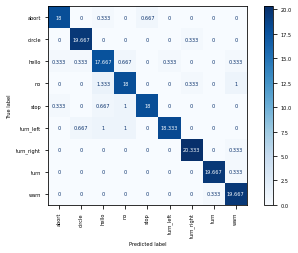

<Figure size 324000x324000 with 0 Axes>

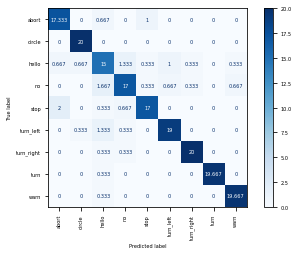

<Figure size 324000x324000 with 0 Axes>

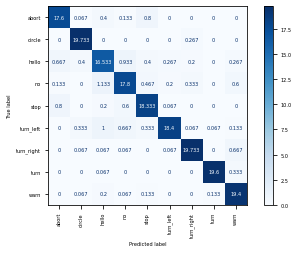

In [140]:
nb_classes = 9
print("===============================")
print("Results for Pause - best case")
best = np.argmax(mean_test_scores_per_trial_snapture_pause)
print("Accuracy:", round(mean_test_scores_per_trial_snapture_pause[best], 5))
print("F1:", round(mean_f1_per_trial_snapture_pause[best], 5))
print("===============================")
displayConfMat(all_conf_avg_snapture_pause[best].round(3), "3_cross_pause_grit_best_30_70_5_9_2021_bigger.png")

print("===============================")
print("Results for Pause - worst case")
worst = np.argmin(mean_test_scores_per_trial_snapture_pause)
print("Accuracy:", round(mean_test_scores_per_trial_snapture_pause[worst], 5))
print("F1:", round(mean_f1_per_trial_snapture_pause[worst], 5))
print("===============================")
displayConfMat(all_conf_avg_snapture_pause[worst].round(3), "3_cross_pause_grit_worst_30_70_5_9_2021_bigger.png")

print("===============================")
print("Results for Pause - avg case")
worst = np.mean(mean_test_scores_per_trial_snapture_pause)
print("Accuracy:", round(np.mean(mean_test_scores_per_trial_snapture_pause), 5))
print("F1:", round(np.mean(mean_f1_per_trial_snapture_pause), 5))
print("===============================")
#temp = []
#for conf in all_confusion:
#    temp.append(np.array(conf))
#print(np.mean(np.array(temp), axis=0))
whatever = np.mean(np.array(all_conf_avg_snapture_pause), axis=0)
displayConfMat(whatever.round(3), "3_cross_pause_grit_avg_30_70_5_9_2021_bigger.png")
